In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
from ydata_profiling import ProfileReport
from scipy import stats as sts
import sklearn 
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer, KNNImputer
sklearn.impute.KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, fbeta_score, precision_recall_curve, average_precision_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import phik
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn  # Если нужно логировать модели sklearn
import os
from mlflow.models import infer_signature
import optuna
from fastapi import FastAPI
import mlflow.pyfunc
from pydantic import BaseModel
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [52]:
mlflow.set_tracking_uri(mlflow.set_tracking_uri("http://192.168.1.104:5000"))
mlflow.set_experiment("client_reliability_exp")

In [26]:
df_customers = pd.read_csv('/home/vivaldi/MyProjects/ssh_first_try/data/credit-risk/customer_data.csv')
df_payments = pd.read_csv('/home/vivaldi/MyProjects/ssh_first_try/data/credit-risk/payment_data.csv')

In [27]:
df_customers

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000


In [28]:
df_payments

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016
...,...,...,...,...,...,...,...,...,...,...,...,...
8245,58995478,0,0,0,0,9,15,NaN,NaN,0.0,NaN,NaN
8246,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN
8247,54988209,0,0,0,0,5,13,NaN,NaN,20654.4,33315.0,NaN
8248,54992408,0,0,0,0,1,2,NaN,NaN,0.0,NaN,NaN


In [29]:
pr = ProfileReport(df_c, title="Clients")
pr.to_file("customer_profile_report.html")

pr2 = ProfileReport(df_p, title="Payments") 
pr2.to_file("payment_profile_report.html")


NameError: name 'df_c' is not defined

In [30]:
df_payments['update_date'].unique()

array(['04/12/2016', '03/12/2016', '02/12/2016', ..., '18/04/1992',
       '19/07/1988', nan], dtype=object)

In [31]:
df_payments['update_date'] = pd.to_datetime(df_payments['update_date'], format='%d/%m/%Y')
df_payments['report_date'] = pd.to_datetime(df_payments['update_date'], format='%d/%m/%Y')



In [32]:
df_payments.dtypes

id                          int64
OVD_t1                      int64
OVD_t2                      int64
OVD_t3                      int64
OVD_sum                     int64
pay_normal                  int64
prod_code                   int64
prod_limit                float64
update_date        datetime64[ns]
new_balance               float64
highest_balance           float64
report_date        datetime64[ns]
dtype: object

In [33]:
grouped = df_payments.groupby('id').agg({
    'OVD_t1': ['mean', 'max'],
    'OVD_t2': ['mean', 'max'],
    'OVD_t3': ['mean', 'max'],
    'pay_normal': ['mean', 'max'],
    'prod_code': 'median',
    'update_date': 'mean',
    'report_date': 'mean',
    'prod_limit': 'mean',
    'new_balance': 'mean',
    'highest_balance': 'mean'
})

grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()
grouped

,id,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
0,54982353,0.166667,1,0.111111,2,2.111111,35,12.722222,35,10.0,2005-09-29 22:40:00.000000000,2005-09-29 22:40:00.000000000,259600.0,42033.133333,246583.714286
1,54982356,0.000000,0,0.000000,0,0.000000,0,16.714286,36,10.0,2002-08-21 00:00:00.000000000,2002-08-21 00:00:00.000000000,330000.0,2277.771429,196649.285714
2,54982387,0.272727,2,0.000000,0,0.000000,0,22.363636,36,6.0,2012-02-23 04:21:49.090909184,2012-02-23 04:21:49.090909184,109450.0,117455.127273,238270.000000
3,54982463,0.000000,0,0.000000,0,0.000000,0,17.000000,19,9.0,2013-03-02 12:00:00.000000000,2013-03-02 12:00:00.000000000,NaN,39890.400000,78500.000000
4,54982530,0.000000,0,0.000000,0,0.000000,0,14.000000,25,10.0,2014-08-18 00:00:00.000000000,2014-08-18 00:00:00.000000000,94600.0,1261.200000,12787.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,59005995,0.000000,0,0.000000,0,0.000000,0,16.333333,27,10.0,2015-01-19 00:00:00.000000000,2015-01-19 00:00:00.000000000,35200.0,57099.600000,105173.666667
1121,59006139,0.000000,0,0.000000,0,0.000000,0,7.250000,20,5.5,2015-09-21 18:00:00.000000000,2015-09-21 18:00:00.000000000,59400.0,14652.300000,49595.750000
1122,59006193,0.000000,0,0.000000,0,0.000000,0,13.250000,33,10.0,2014-08-17 00:00:00.000000000,2014-08-17 00:00:00.000000000,105160.0,13651.350000,50328.625000
1123,59006219,0.333333,1,0.000000,0,0.000000,0,27.000000,36,10.0,2013-10-20 08:00:00.000000000,2013-10-20 08:00:00.000000000,33000.0,179909.200000,189248.666667


In [34]:
grouped = round(grouped, 2)

In [35]:
grouped['update_date_mean'] = grouped['update_date_mean'].dt.floor('d')
grouped['report_date_mean'] = grouped['report_date_mean'].dt.floor('d')

In [36]:
grouped

,id,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
0,54982353,0.17,1,0.11,2,2.11,35,12.72,35,10.0,2005-09-29,2005-09-29,259600.0,42033.13,246583.71
1,54982356,0.00,0,0.00,0,0.00,0,16.71,36,10.0,2002-08-21,2002-08-21,330000.0,2277.77,196649.29
2,54982387,0.27,2,0.00,0,0.00,0,22.36,36,6.0,2012-02-23,2012-02-23,109450.0,117455.13,238270.00
3,54982463,0.00,0,0.00,0,0.00,0,17.00,19,9.0,2013-03-02,2013-03-02,NaN,39890.40,78500.00
4,54982530,0.00,0,0.00,0,0.00,0,14.00,25,10.0,2014-08-18,2014-08-18,94600.0,1261.20,12787.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,59005995,0.00,0,0.00,0,0.00,0,16.33,27,10.0,2015-01-19,2015-01-19,35200.0,57099.60,105173.67
1121,59006139,0.00,0,0.00,0,0.00,0,7.25,20,5.5,2015-09-21,2015-09-21,59400.0,14652.30,49595.75
1122,59006193,0.00,0,0.00,0,0.00,0,13.25,33,10.0,2014-08-17,2014-08-17,105160.0,13651.35,50328.62
1123,59006219,0.33,1,0.00,0,0.00,0,27.00,36,10.0,2013-10-20,2013-10-20,33000.0,179909.20,189248.67


In [37]:
df_customers

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000


In [38]:
df_customers.dtypes

label       int64
id          int64
fea_1       int64
fea_2     float64
fea_3       int64
fea_4     float64
fea_5       int64
fea_6       int64
fea_7       int64
fea_8       int64
fea_9       int64
fea_10      int64
fea_11    float64
dtype: object

In [39]:
df = df_customers.merge(grouped, on='id')

In [40]:
df[df.index == 2]

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.0,0.0,0,0.0,0,0.0,0,10.67,23,7.5,2015-03-15,2015-03-15,102300.0,109178.8,118865.67


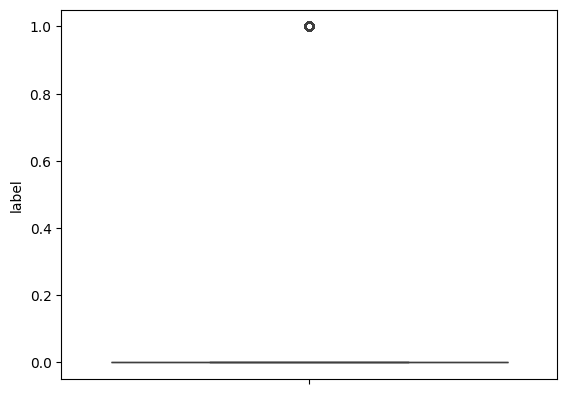

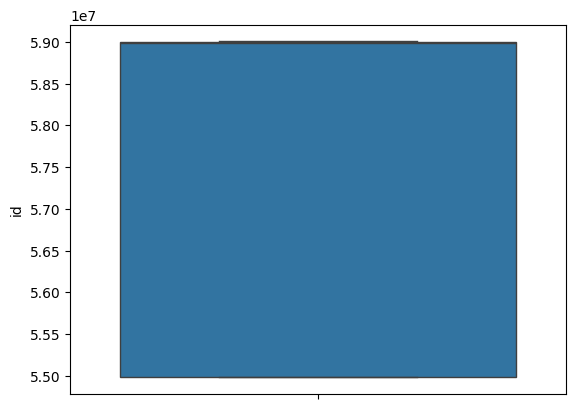

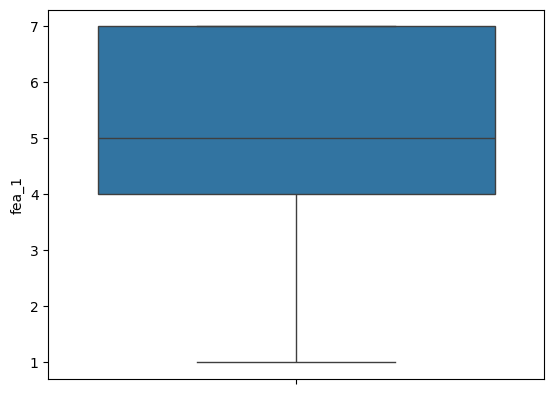

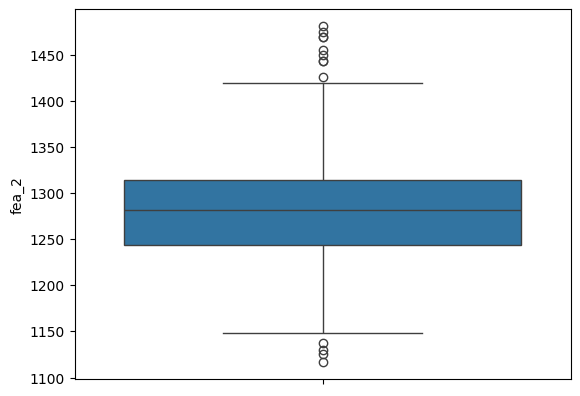

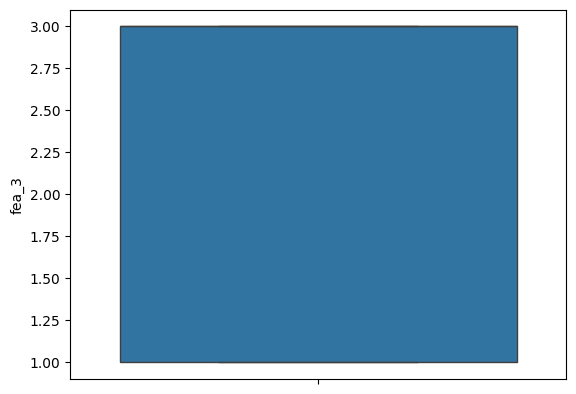

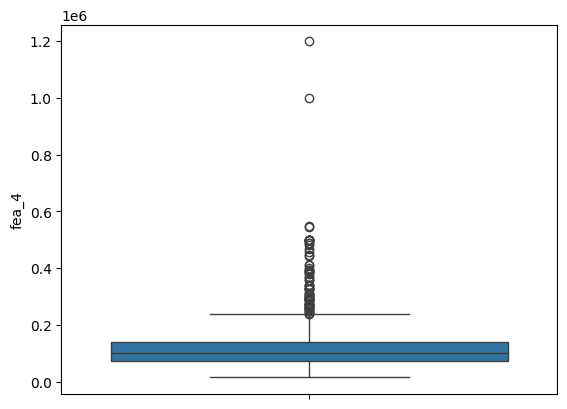

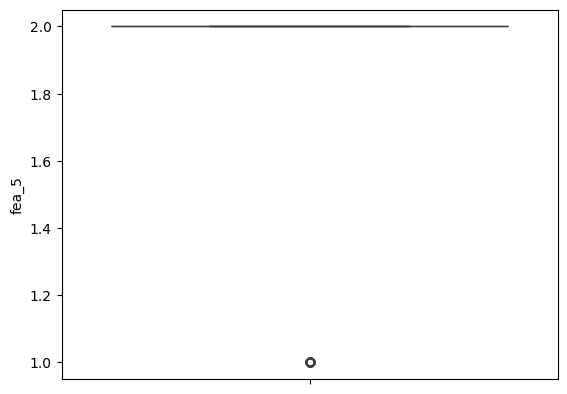

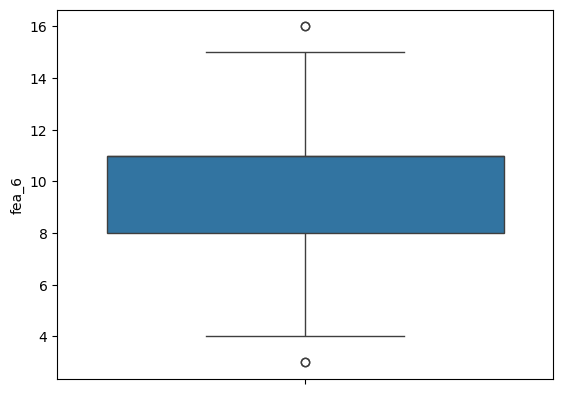

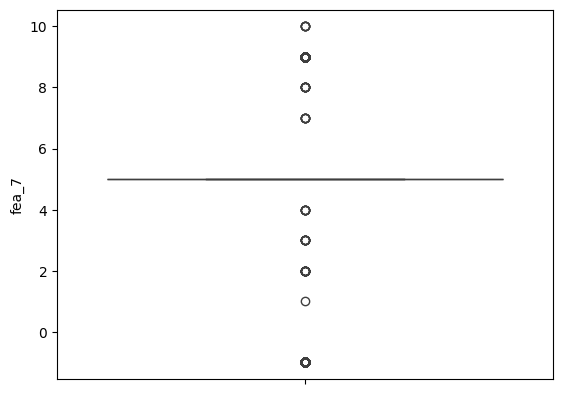

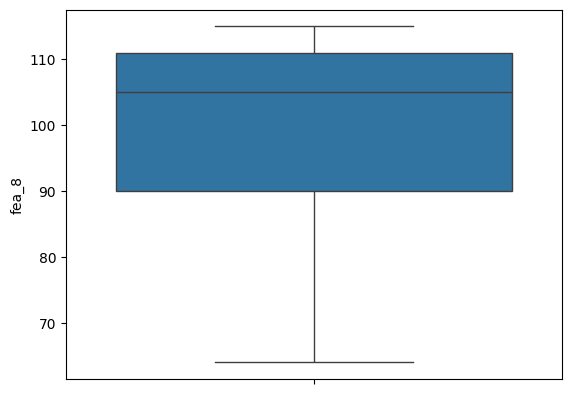

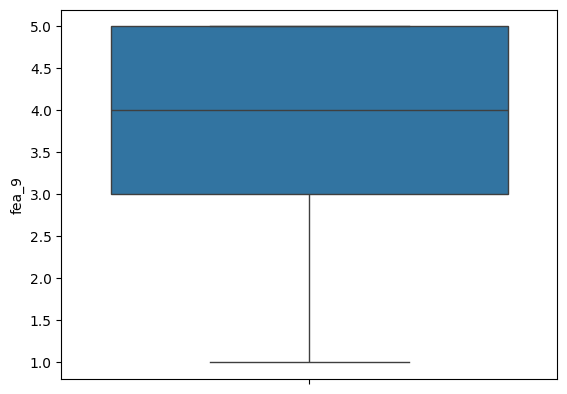

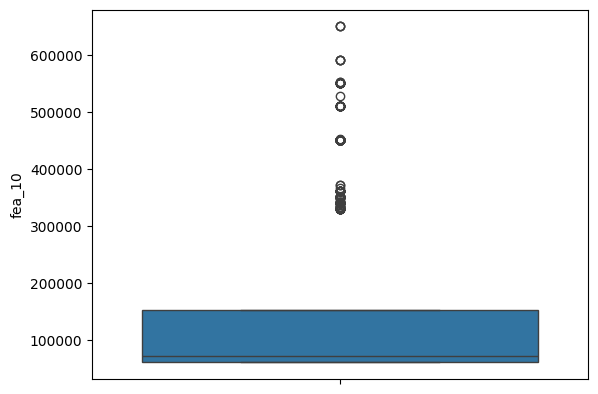

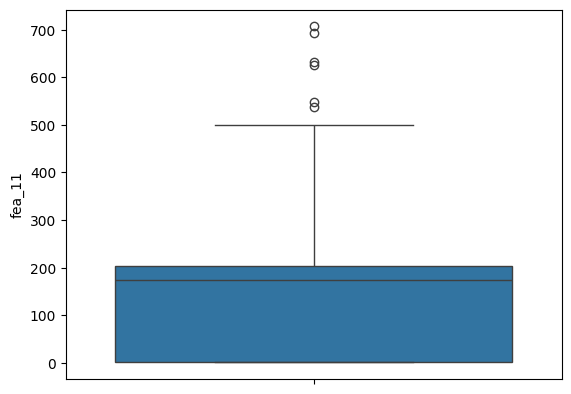

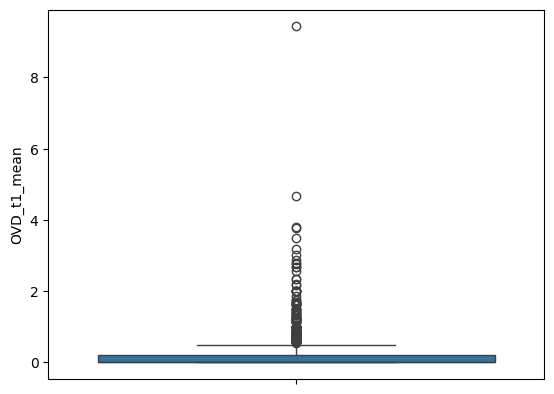

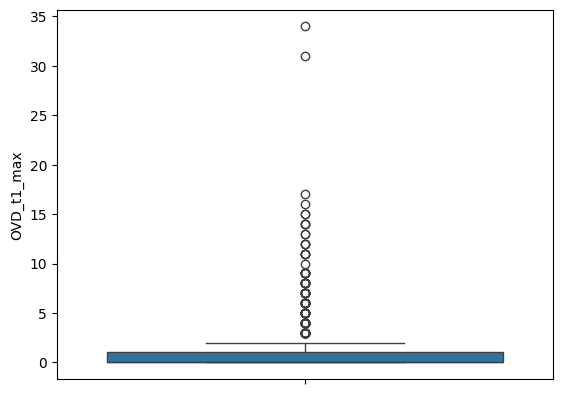

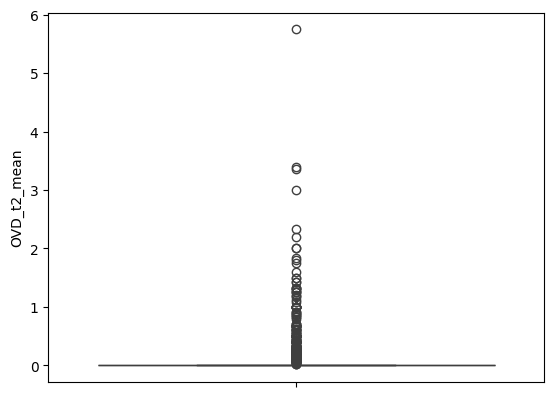

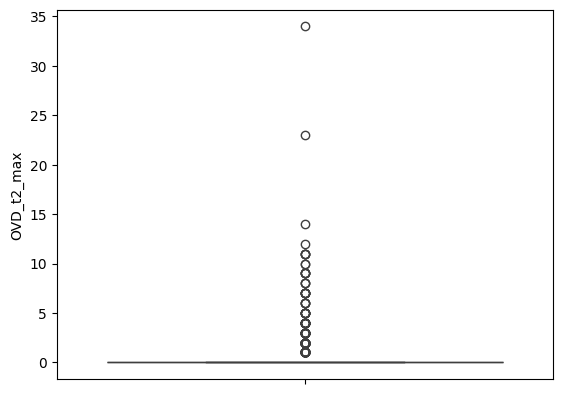

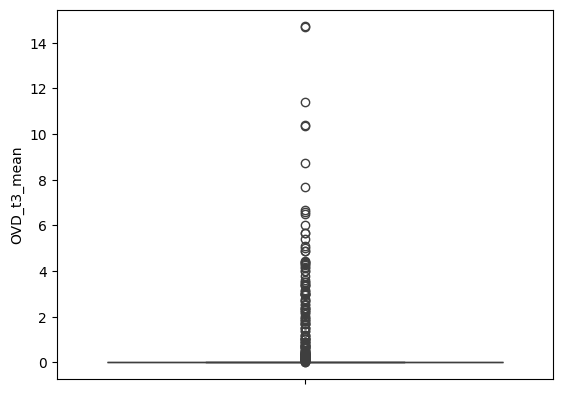

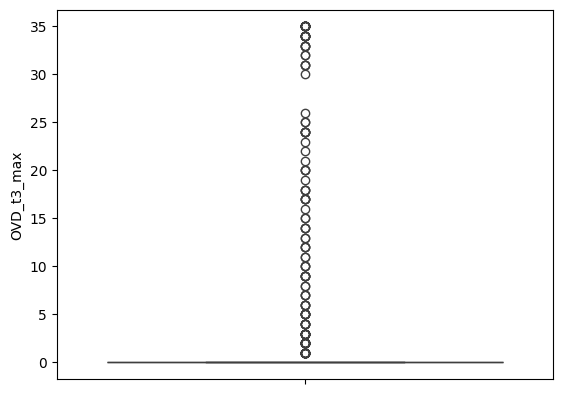

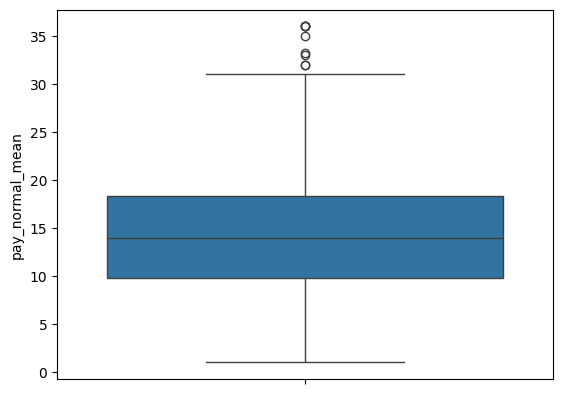

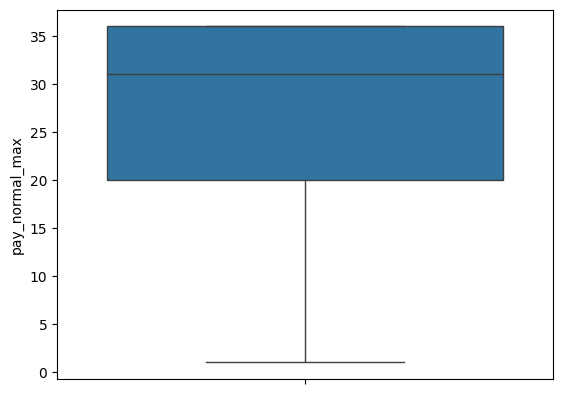

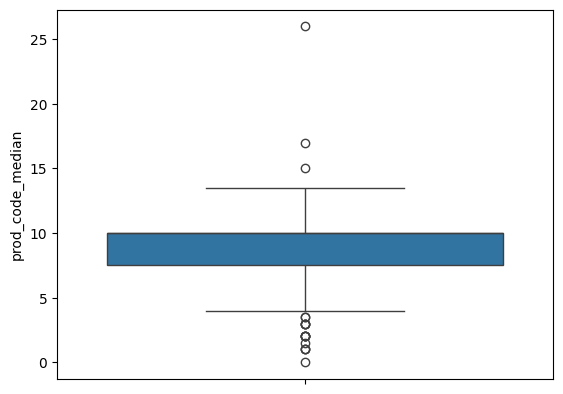

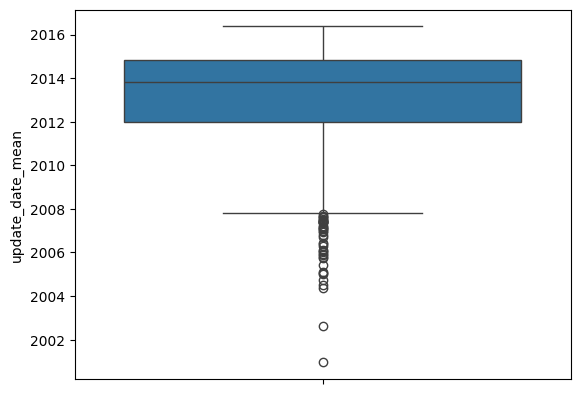

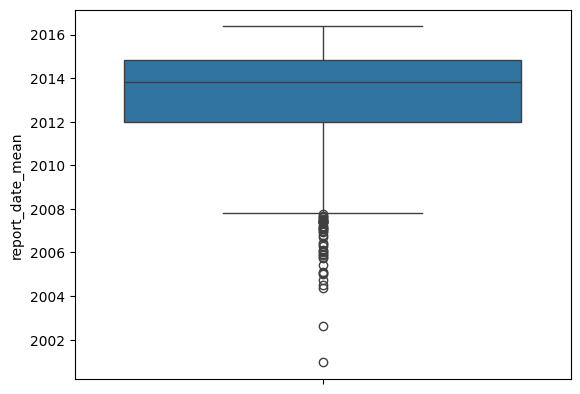

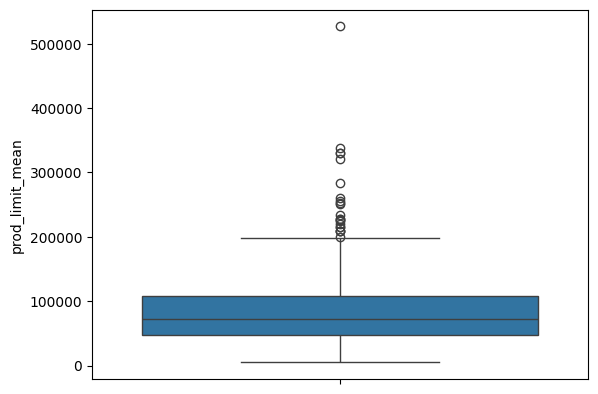

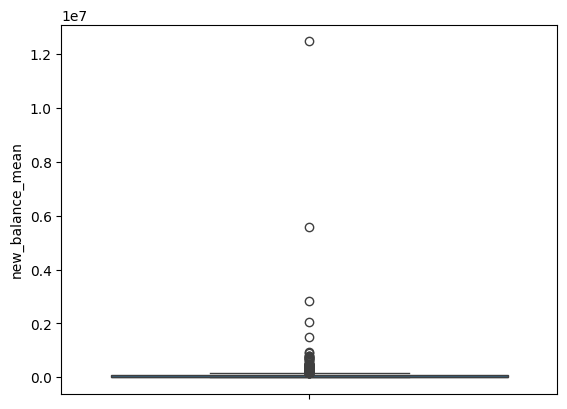

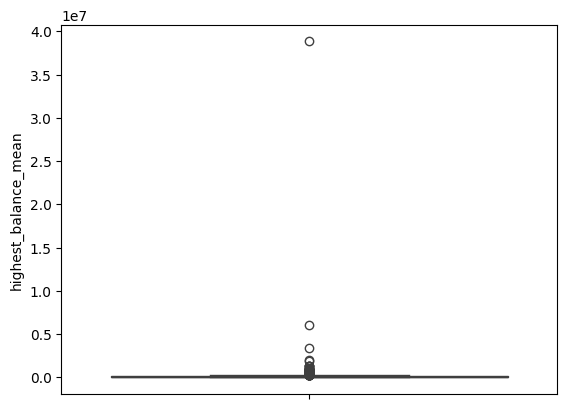

In [41]:
for i in df.columns:
    sns.boxplot(df[i])
    plt.show()

In [42]:
df['update_date_mean'] = (df['update_date_mean'] - df['update_date_mean'].min()).dt.days
df['report_date_mean'] = (df['report_date_mean'] - df['report_date_mean'].min()).dt.days

In [43]:
df[df['highest_balance_mean'] == df['highest_balance_mean'].max()]

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
103,1,58989344,7,1265.0,3,70000.0,2,11,-1,81,5,350704,316.227766,1.27,7,0.4,3,0.0,0,16.53,36,3.0,3415,3415,143000.0,12475780.4,38846604.31


In [44]:
X = df.drop(columns='label')
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [59]:
y_test.to_csv('y_test.csv', index=False)


In [45]:
X_train

,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
840,59000851,4,1302.5,3,410000.0,2,8,9,84,5,60018,1.000000,0.00,0,0.00,0,0.00,0,22.00,36,10.0,4563,4563,142037.50,4641.8,34437.67
79,59003122,4,1278.5,3,115000.0,2,8,5,99,3,72000,173.205081,0.00,0,0.00,0,0.00,0,22.00,32,10.0,4895,4895,108900.00,561.0,20259.50
735,58986218,5,1191.5,3,61000.0,2,15,-1,111,4,72001,1.000000,0.17,1,0.00,0,0.00,0,14.50,36,10.0,5046,5046,63066.67,49682.4,71338.80
683,54985173,7,1245.5,3,68000.0,2,11,5,111,4,60091,200.000000,0.00,0,0.00,0,0.00,0,16.67,35,10.0,4906,4906,117700.00,33994.4,45238.00
582,59001375,4,1305.5,3,65000.0,2,8,9,80,5,60041,204.939015,0.00,0,0.00,0,0.00,0,18.00,18,10.0,4892,4892,NaN,5385.6,29889.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,54992046,4,1257.5,1,91000.0,2,8,5,90,3,72000,1.000000,0.00,0,0.00,0,0.00,0,5.50,9,10.0,5442,5442,49500.00,7191.0,7927.50
7,54984789,5,1256.0,3,78000.0,2,15,-1,111,3,60030,1.000000,1.00,3,0.25,1,0.00,0,20.00,31,10.0,4863,4863,26033.33,23073.6,32487.75
145,59002016,4,1196.0,3,65000.0,2,8,-1,108,4,72001,1.000000,1.25,5,0.00,0,0.00,0,18.75,36,10.0,4943,4943,98450.00,25715.4,53975.50
897,58991782,7,1229.0,3,50000.0,2,12,-1,103,3,350061,200.239856,1.67,5,1.33,4,0.00,0,15.33,23,10.0,4589,4589,28050.00,15266.4,35616.67


In [46]:
X_test

,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
790,54989322,4,NaN,2,54000.0,2,8,5,89,5,72016,189.736660,0.00,0,0.00,0,0.0,0,4.75,8,10.0,5400,5400,41800.00,184770.00,165776.00
500,58997555,4,1266.5,3,207000.0,2,9,5,100,1,71002,316.227766,0.00,0,0.00,0,0.0,0,16.25,36,10.0,3338,3338,214912.50,15885.20,30608.52
949,54986075,7,1245.5,3,81000.0,2,11,5,103,5,60014,1.000000,1.50,5,0.12,1,0.0,0,16.88,36,8.5,3121,3121,58850.00,127.50,90722.62
795,58992134,7,1235.0,1,114000.0,2,11,-1,85,5,450088,1.000000,0.00,0,0.00,0,0.0,0,6.73,22,10.0,4662,4662,83380.00,11190.64,55587.20
193,58985009,5,1367.0,3,167000.0,2,15,5,95,5,60021,244.948974,0.33,1,0.00,0,0.0,0,26.00,36,10.0,4536,4536,127600.00,346999.20,686619.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,58997757,4,NaN,2,71000.0,2,8,9,90,5,72015,167.496269,0.00,0,0.00,0,0.0,0,8.43,24,10.0,4824,4824,49353.33,6404.57,46713.00
1021,54991742,4,1245.5,3,50000.0,2,8,5,88,3,340017,300.000000,0.19,5,0.06,2,0.0,0,13.81,36,6.0,3702,3702,97075.00,109809.41,208479.33
162,59001343,4,1272.5,3,170000.0,2,8,5,110,4,60019,1.000000,0.00,0,0.00,0,0.0,0,18.50,27,10.0,5066,5066,87450.00,1789.20,21593.25
514,58987165,5,1317.5,1,89000.0,2,15,9,114,4,450080,178.137587,0.00,0,0.00,0,0.0,0,24.67,36,10.0,4495,4495,133760.00,107613.07,171518.78


<Axes: >

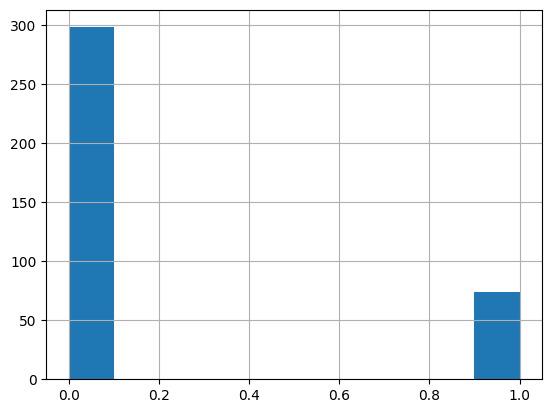

In [47]:
y_test.hist()

<Axes: >

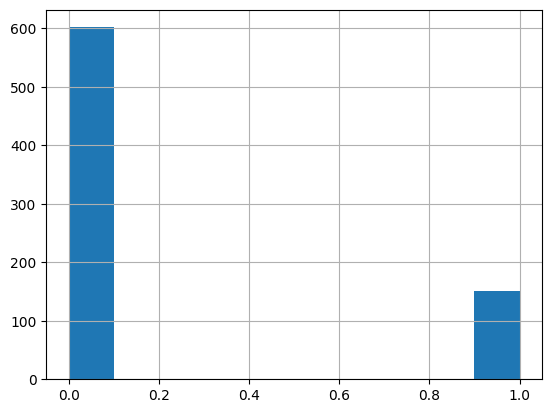

In [48]:
y_train.hist()

In [55]:
def create_pipeline(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10)
    model = trial.suggest_categorical('model', ['lgbm', 'catboost', 'xgbm'])
    
    if model == 'lgbm':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 30)
        classifier = LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 0.0, 5.0),
            reg_lambda=trial.suggest_float('reg_lambda', 0.0, 5.0),
            min_split_gain=trial.suggest_float('min_split_gain', 0.0, 1.0),
            min_child_weight=trial.suggest_float('min_child_weight', 1e-3, 10.0),
            random_state=42
        )
    elif model == 'catboost':
        depth = trial.suggest_int('depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
        classifier = CatBoostClassifier(
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            random_state=42
        )
        
    else:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
        min_child_weight = trial.suggest_float('min_child_weight', 1.0, 7.0)  # Consistent float distribution
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 5) 
        reg_lambda = trial.suggest_float('reg_lambda', 0, 5)
        classifier = XGBClassifier(
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   min_child_weight=min_child_weight,
                                   subsample=subsample,
                                   colsample_bytree=colsample_bytree,
                                   gamma=gamma,
                                   reg_alpha=reg_alpha,
                                   reg_lambda=reg_lambda,
                                   random_state=42
                                   )
        
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=n_neighbors)),
        ('scaler', PowerTransformer()),
        ('model', classifier)
    ])
    
    return pipeline
        
        
def objective(trial):
    pipeline_opt = create_pipeline(trial)
    
    pipeline_opt.fit(X_train, y_train)
    predictions = pipeline_opt.predict(X_test)
    
    metric = f1_score(y_test, predictions, average='weighted')
    
    return metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_trial = study.best_trial
best_pipeline = create_pipeline(best_trial)

mlflow.set_tracking_uri(mlflow.set_tracking_uri("http://192.168.1.104:5000"))
mlflow.set_experiment("client_reliability_exp")

with mlflow.start_run():
    mlflow.log_params(best_trial.params)
    
    best_pipeline.fit(X_train, y_train)
    predictions = best_pipeline.predict(X_test)
    prob = best_pipeline.predict_proba(X_test)
    
    f1 = f1_score(y_test, predictions, average='weighted')
    accuracy = accuracy_score(y_test, predictions)
    recall, precision, _ = precision_recall_curve(y_test, prob[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])
    fbeta = fbeta_score(y_test, predictions, beta=1.5)
    b_acc = balanced_accuracy_score(y_test, predictions)
    
    mlflow.log_metrics({
    "f1": f1,
    "accuracy": accuracy,
    'fbeta': fbeta,
    'balanced_accuracy': b_acc
    })
    mlflow.log_metric("Best Objective Value", study.best_value)
    
    example_input = X_test[:5]
    signature = infer_signature(X_test, best_pipeline.predict(X_test))
    mlflow.sklearn.log_model(best_pipeline, "model_pipeline", signature=signature, input_example=example_input)
    
    # Create and log PR curve
    plt.figure()
    plt.plot(recall, precision)
    plt.title('Best Model PR-curve')
    mlflow.log_figure(plt.gcf(), "pr_curve.png")
    plt.close()
    
    # Create and log ROC curve 
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title('Best Model ROC-curve')
    mlflow.log_figure(plt.gcf(), "roc_curve.png")
    plt.close()


    

[I 2025-03-13 21:39:30,277] A new study created in memory with name: no-name-0d0f8b00-1233-45f3-9c81-efa55172b32f
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-03-13 21:39:30,374] Trial 0 finished with value: 0.734939254294093 and parameters: {'n_neighbors': 9, 'model': 'lgbm', 'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.051873938964354674, 'num_leaves': 48, 'min_child_samples': 28, 'subsample': 0.9054810164506636, 'colsample_bytre

[LightGBM] [Info] Number of positive: 151, number of negative: 602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200531 -> initscore=-1.382978
[LightGBM] [Info] Start training from score -1.382978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-03-13 21:39:30,582] Trial 1 finished with value: 0.7293551738553452 and parameters: {'n_neighbors': 7, 'model': 'lgbm', 'n_estimators': 925, 'max_depth': 3, 'learning_rate': 0.05930794271831276, 'num_leaves': 31, 'min_child_samples': 18, 'subsample': 0.7751440876841871, 'colsample_bytree': 0.6357760553065566, 'reg_alpha': 1.2842722660627555, 'reg_lambda': 0.9946084907351527, 'min_split_gain': 0.451298637031876, 'min_child_weight': 5.319393215465023}. Best is trial 0 with value: 0.734939254294093.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-03-13 21:39:31,419] Trial 2 finished with value: 0.760765076061642 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 6, 'learning_rate': 0.09247380250750223, 'l2_leaf_reg': 9.885962243853216}. Best is trial 2 with value: 0.760765076061642.


899:	learn: 0.0238132	total: 650ms	remaining: 72.2ms
900:	learn: 0.0237191	total: 651ms	remaining: 71.5ms
901:	learn: 0.0237159	total: 652ms	remaining: 70.8ms
902:	learn: 0.0236179	total: 653ms	remaining: 70.1ms
903:	learn: 0.0235622	total: 653ms	remaining: 69.4ms
904:	learn: 0.0234971	total: 654ms	remaining: 68.6ms
905:	learn: 0.0234512	total: 655ms	remaining: 67.9ms
906:	learn: 0.0234361	total: 655ms	remaining: 67.2ms
907:	learn: 0.0234328	total: 656ms	remaining: 66.5ms
908:	learn: 0.0234174	total: 657ms	remaining: 65.7ms
909:	learn: 0.0233371	total: 657ms	remaining: 65ms
910:	learn: 0.0233343	total: 658ms	remaining: 64.3ms
911:	learn: 0.0233314	total: 658ms	remaining: 63.5ms
912:	learn: 0.0232977	total: 659ms	remaining: 62.8ms
913:	learn: 0.0232955	total: 660ms	remaining: 62.1ms
914:	learn: 0.0232005	total: 660ms	remaining: 61.3ms
915:	learn: 0.0230889	total: 661ms	remaining: 60.6ms
916:	learn: 0.0230847	total: 662ms	remaining: 59.9ms
917:	learn: 0.0230824	total: 662ms	remaining: 59

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-03-13 21:39:31,611] Trial 3 finished with value: 0.7161662151747753 and parameters: {'n_neighbors': 8, 'model': 'xgbm', 'max_depth': 7, 'learning_rate': 0.024070995700576782, 'min_child_weight': 3.5444168091767847, 'subsample': 0.5585219171771936, 'colsample_bytree': 0.7476143202510415, 'gamma': 1.0894716160995128, 'reg_alpha': 0.6466745553422021, 'reg_lambda': 2.9004666768140934}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vival

0:	learn: 0.6566009	total: 22.7ms	remaining: 22.7s
1:	learn: 0.6253524	total: 32.1ms	remaining: 16s
2:	learn: 0.5956936	total: 42.2ms	remaining: 14s
3:	learn: 0.5733963	total: 51ms	remaining: 12.7s
4:	learn: 0.5524825	total: 59.7ms	remaining: 11.9s
5:	learn: 0.5317941	total: 69.6ms	remaining: 11.5s
6:	learn: 0.5110948	total: 79.6ms	remaining: 11.3s
7:	learn: 0.4926226	total: 89.4ms	remaining: 11.1s
8:	learn: 0.4760384	total: 99.7ms	remaining: 11s
9:	learn: 0.4644437	total: 108ms	remaining: 10.7s
10:	learn: 0.4470543	total: 118ms	remaining: 10.6s
11:	learn: 0.4327653	total: 128ms	remaining: 10.6s
12:	learn: 0.4201087	total: 138ms	remaining: 10.5s
13:	learn: 0.4124935	total: 149ms	remaining: 10.5s
14:	learn: 0.4051586	total: 160ms	remaining: 10.5s
15:	learn: 0.3992191	total: 170ms	remaining: 10.5s
16:	learn: 0.3932354	total: 181ms	remaining: 10.4s
17:	learn: 0.3852079	total: 189ms	remaining: 10.3s
18:	learn: 0.3773170	total: 200ms	remaining: 10.3s
19:	learn: 0.3676701	total: 209ms	remain

[I 2025-03-13 21:39:41,600] Trial 5 finished with value: 0.751089349516826 and parameters: {'n_neighbors': 8, 'model': 'catboost', 'depth': 9, 'learning_rate': 0.06759942034540128, 'l2_leaf_reg': 3.2570342132968078}. Best is trial 2 with value: 0.760765076061642.


998:	learn: 0.0049989	total: 9.53s	remaining: 9.54ms
999:	learn: 0.0049928	total: 9.54s	remaining: 0us
[LightGBM] [Info] Number of positive: 151, number of negative: 602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200531 -> initscore=-1.382978
[LightGBM] [Info] Start training from score -1.382978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-03-13 21:39:41,768] Trial 6 finished with value: 0.7161662151747753 and parameters: {'n_neighbors': 6, 'model': 'lgbm', 'n_estimators': 959, 'max_depth': 7, 'learning_rate': 0.07346199297052694, 'num_leaves': 44, 'min_child_samples': 16, 'subsample': 0.6521002892867824, 'colsample_bytree': 0.7525018533571568, 'reg_alpha': 3.619969875408491, 'reg_lambda': 3.948883630145763, 'min_split_gain': 0.62029

0:	learn: 0.6581081	total: 5.5ms	remaining: 5.49s
1:	learn: 0.6258645	total: 6.24ms	remaining: 3.11s
2:	learn: 0.6001210	total: 7.14ms	remaining: 2.37s
3:	learn: 0.5758536	total: 8.2ms	remaining: 2.04s
4:	learn: 0.5567074	total: 13ms	remaining: 2.58s
5:	learn: 0.5416339	total: 13.6ms	remaining: 2.25s
6:	learn: 0.5274174	total: 14.2ms	remaining: 2.01s
7:	learn: 0.5147911	total: 14.8ms	remaining: 1.83s
8:	learn: 0.5038326	total: 15.4ms	remaining: 1.69s
9:	learn: 0.4943228	total: 15.9ms	remaining: 1.58s
10:	learn: 0.4842941	total: 16.5ms	remaining: 1.49s
11:	learn: 0.4756274	total: 17.6ms	remaining: 1.45s
12:	learn: 0.4672395	total: 18.7ms	remaining: 1.42s
13:	learn: 0.4607072	total: 19.5ms	remaining: 1.37s
14:	learn: 0.4524272	total: 20.6ms	remaining: 1.35s
15:	learn: 0.4492288	total: 21.8ms	remaining: 1.34s
16:	learn: 0.4449833	total: 23.1ms	remaining: 1.33s
17:	learn: 0.4391754	total: 23.9ms	remaining: 1.3s
18:	learn: 0.4352443	total: 25.1ms	remaining: 1.3s
19:	learn: 0.4326987	total: 

[I 2025-03-13 21:39:42,477] Trial 7 finished with value: 0.7522003414110483 and parameters: {'n_neighbors': 6, 'model': 'catboost', 'depth': 5, 'learning_rate': 0.07728885199939242, 'l2_leaf_reg': 5.450767761785293}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-03-13 21:39:42,613] Trial 8 finished with value: 0.7325192981950308 and parameters: {'n_neighbors': 6, 'model': 'lgbm', 'n_estimators': 6

[LightGBM] [Info] Number of positive: 151, number of negative: 602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200531 -> initscore=-1.382978
[LightGBM] [Info] Start training from score -1.382978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-03-13 21:39:42,762] Trial 9 finished with value: 0.7112686243309707 and parameters: {'n_neighbors': 9, 'model': 'xgbm', 'max_depth': 6, 'learning_rate': 0.025411551419212995, 'min_child_weight': 1.923392211727406, 'subsample': 0.8779398152701305, 'colsample_bytree': 0.9040863106289043, 'gamma': 3.400230757822179, 'reg_alpha': 1.604874418700632, 'reg_lambda': 1.0502452921252896}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6497301	total: 5.39ms	remaining: 5.39s
1:	learn: 0.6186396	total: 5.83ms	remaining: 2.91s
2:	learn: 0.5907859	total: 6.58ms	remaining: 2.19s
3:	learn: 0.5649328	total: 7.01ms	remaining: 1.74s
4:	learn: 0.5492572	total: 7.5ms	remaining: 1.49s
5:	learn: 0.5344936	total: 8.01ms	remaining: 1.33s
6:	learn: 0.5197620	total: 8.78ms	remaining: 1.25s
7:	learn: 0.5074289	total: 9.51ms	remaining: 1.18s
8:	learn: 0.4990975	total: 10.3ms	remaining: 1.14s
9:	learn: 0.4898977	total: 11.1ms	remaining: 1.1s
10:	learn: 0.4819144	total: 11.9ms	remaining: 1.07s
11:	learn: 0.4766859	total: 12.6ms	remaining: 1.04s
12:	learn: 0.4699542	total: 13.4ms	remaining: 1.01s
13:	learn: 0.4661197	total: 14.3ms	remaining: 1.01s
14:	learn: 0.4633518	total: 15.2ms	remaining: 996ms
15:	learn: 0.4604202	total: 15.9ms	remaining: 976ms
16:	learn: 0.4561084	total: 16.7ms	remaining: 964ms
17:	learn: 0.4529659	total: 17.4ms	remaining: 949ms
18:	learn: 0.4495826	total: 18.2ms	remaining: 939ms
19:	learn: 0.4483788	tot

[I 2025-03-13 21:39:43,352] Trial 10 finished with value: 0.7306263041776295 and parameters: {'n_neighbors': 3, 'model': 'catboost', 'depth': 3, 'learning_rate': 0.09874799169160194, 'l2_leaf_reg': 9.955374528331433}. Best is trial 2 with value: 0.760765076061642.


861:	learn: 0.0961719	total: 359ms	remaining: 57.5ms
862:	learn: 0.0958709	total: 360ms	remaining: 57.1ms
863:	learn: 0.0957805	total: 360ms	remaining: 56.7ms
864:	learn: 0.0955778	total: 361ms	remaining: 56.3ms
865:	learn: 0.0953480	total: 361ms	remaining: 55.8ms
866:	learn: 0.0951965	total: 361ms	remaining: 55.4ms
867:	learn: 0.0951913	total: 362ms	remaining: 55ms
868:	learn: 0.0950470	total: 362ms	remaining: 54.6ms
869:	learn: 0.0949649	total: 363ms	remaining: 54.2ms
870:	learn: 0.0948631	total: 363ms	remaining: 53.7ms
871:	learn: 0.0947854	total: 363ms	remaining: 53.3ms
872:	learn: 0.0947691	total: 364ms	remaining: 52.9ms
873:	learn: 0.0946945	total: 364ms	remaining: 52.5ms
874:	learn: 0.0945747	total: 364ms	remaining: 52.1ms
875:	learn: 0.0945635	total: 365ms	remaining: 51.6ms
876:	learn: 0.0942673	total: 365ms	remaining: 51.2ms
877:	learn: 0.0942616	total: 366ms	remaining: 50.8ms
878:	learn: 0.0940011	total: 366ms	remaining: 50.4ms
879:	learn: 0.0938496	total: 366ms	remaining: 50

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


23:	learn: 0.4005620	total: 28ms	remaining: 1.14s
24:	learn: 0.3965576	total: 28.8ms	remaining: 1.12s
25:	learn: 0.3943488	total: 29.5ms	remaining: 1.1s
26:	learn: 0.3927508	total: 30.1ms	remaining: 1.08s
27:	learn: 0.3913143	total: 30.8ms	remaining: 1.07s
28:	learn: 0.3890054	total: 31.5ms	remaining: 1.05s
29:	learn: 0.3874178	total: 32.2ms	remaining: 1.04s
30:	learn: 0.3861227	total: 32.8ms	remaining: 1.03s
31:	learn: 0.3851741	total: 33.5ms	remaining: 1.01s
32:	learn: 0.3820456	total: 34.2ms	remaining: 1s
33:	learn: 0.3816613	total: 34.8ms	remaining: 989ms
34:	learn: 0.3810636	total: 35.5ms	remaining: 979ms
35:	learn: 0.3805013	total: 36.4ms	remaining: 975ms
36:	learn: 0.3798444	total: 37.3ms	remaining: 971ms
37:	learn: 0.3792641	total: 38.8ms	remaining: 983ms
38:	learn: 0.3789117	total: 39.8ms	remaining: 980ms
39:	learn: 0.3773104	total: 40.6ms	remaining: 973ms
40:	learn: 0.3767584	total: 41.1ms	remaining: 961ms
41:	learn: 0.3737264	total: 41.6ms	remaining: 950ms
42:	learn: 0.37206

[I 2025-03-13 21:39:44,053] Trial 11 finished with value: 0.7413477593000736 and parameters: {'n_neighbors': 4, 'model': 'catboost', 'depth': 5, 'learning_rate': 0.09745935898891869, 'l2_leaf_reg': 7.721226871694385}. Best is trial 2 with value: 0.760765076061642.


731:	learn: 0.0344866	total: 404ms	remaining: 148ms
732:	learn: 0.0344812	total: 405ms	remaining: 148ms
733:	learn: 0.0344349	total: 406ms	remaining: 147ms
734:	learn: 0.0343750	total: 406ms	remaining: 146ms
735:	learn: 0.0342260	total: 407ms	remaining: 146ms
736:	learn: 0.0341919	total: 407ms	remaining: 145ms
737:	learn: 0.0341823	total: 408ms	remaining: 145ms
738:	learn: 0.0339953	total: 408ms	remaining: 144ms
739:	learn: 0.0338541	total: 409ms	remaining: 144ms
740:	learn: 0.0338467	total: 409ms	remaining: 143ms
741:	learn: 0.0338065	total: 410ms	remaining: 143ms
742:	learn: 0.0336976	total: 410ms	remaining: 142ms
743:	learn: 0.0336929	total: 411ms	remaining: 141ms
744:	learn: 0.0336041	total: 412ms	remaining: 141ms
745:	learn: 0.0335811	total: 412ms	remaining: 140ms
746:	learn: 0.0334842	total: 413ms	remaining: 140ms
747:	learn: 0.0334314	total: 413ms	remaining: 139ms
748:	learn: 0.0334232	total: 414ms	remaining: 139ms
749:	learn: 0.0333732	total: 414ms	remaining: 138ms
750:	learn: 

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6526929	total: 2.32ms	remaining: 2.32s
1:	learn: 0.6185330	total: 4.5ms	remaining: 2.24s
2:	learn: 0.5901461	total: 6.26ms	remaining: 2.08s
3:	learn: 0.5659783	total: 7.7ms	remaining: 1.92s
4:	learn: 0.5468334	total: 9.01ms	remaining: 1.79s
5:	learn: 0.5299891	total: 10.4ms	remaining: 1.72s
6:	learn: 0.5128255	total: 13.3ms	remaining: 1.88s
7:	learn: 0.4978545	total: 14.8ms	remaining: 1.83s
8:	learn: 0.4836059	total: 17.9ms	remaining: 1.97s
9:	learn: 0.4691302	total: 19.6ms	remaining: 1.94s
10:	learn: 0.4580979	total: 21.3ms	remaining: 1.91s
11:	learn: 0.4501945	total: 22.7ms	remaining: 1.87s
12:	learn: 0.4455952	total: 24.2ms	remaining: 1.84s
13:	learn: 0.4413474	total: 25.8ms	remaining: 1.82s
14:	learn: 0.4348405	total: 27.5ms	remaining: 1.81s
15:	learn: 0.4264542	total: 28.9ms	remaining: 1.78s
16:	learn: 0.4191305	total: 30.8ms	remaining: 1.78s
17:	learn: 0.4151818	total: 32.1ms	remaining: 1.75s
18:	learn: 0.4107444	total: 33.3ms	remaining: 1.72s
19:	learn: 0.4056178	tot

[I 2025-03-13 21:39:44,889] Trial 12 finished with value: 0.7490757391935342 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 6, 'learning_rate': 0.08489188981948984, 'l2_leaf_reg': 5.328344654735408}. Best is trial 2 with value: 0.760765076061642.


822:	learn: 0.0176096	total: 575ms	remaining: 124ms
823:	learn: 0.0175932	total: 576ms	remaining: 123ms
824:	learn: 0.0175552	total: 577ms	remaining: 122ms
825:	learn: 0.0175523	total: 578ms	remaining: 122ms
826:	learn: 0.0175444	total: 578ms	remaining: 121ms
827:	learn: 0.0175060	total: 579ms	remaining: 120ms
828:	learn: 0.0174500	total: 580ms	remaining: 120ms
829:	learn: 0.0174274	total: 580ms	remaining: 119ms
830:	learn: 0.0173711	total: 581ms	remaining: 118ms
831:	learn: 0.0172976	total: 582ms	remaining: 117ms
832:	learn: 0.0172444	total: 582ms	remaining: 117ms
833:	learn: 0.0171745	total: 583ms	remaining: 116ms
834:	learn: 0.0171718	total: 584ms	remaining: 115ms
835:	learn: 0.0171551	total: 584ms	remaining: 115ms
836:	learn: 0.0170488	total: 585ms	remaining: 114ms
837:	learn: 0.0170216	total: 586ms	remaining: 113ms
838:	learn: 0.0169678	total: 586ms	remaining: 113ms
839:	learn: 0.0169210	total: 587ms	remaining: 112ms
840:	learn: 0.0168946	total: 588ms	remaining: 111ms
841:	learn: 

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6518272	total: 5.01ms	remaining: 5s
1:	learn: 0.6159701	total: 26.5ms	remaining: 13.2s
2:	learn: 0.5878359	total: 27.6ms	remaining: 9.16s
3:	learn: 0.5604864	total: 28.9ms	remaining: 7.2s
4:	learn: 0.5384885	total: 30ms	remaining: 5.96s
5:	learn: 0.5188923	total: 30.9ms	remaining: 5.13s
6:	learn: 0.4992170	total: 31.9ms	remaining: 4.53s
7:	learn: 0.4896554	total: 32.9ms	remaining: 4.08s
8:	learn: 0.4751701	total: 33.8ms	remaining: 3.72s
9:	learn: 0.4656318	total: 34.8ms	remaining: 3.44s
10:	learn: 0.4550863	total: 35.9ms	remaining: 3.23s
11:	learn: 0.4448618	total: 37.3ms	remaining: 3.07s
12:	learn: 0.4372751	total: 38.1ms	remaining: 2.89s
13:	learn: 0.4285368	total: 39.1ms	remaining: 2.75s
14:	learn: 0.4221858	total: 40ms	remaining: 2.62s
15:	learn: 0.4161164	total: 40.9ms	remaining: 2.51s
16:	learn: 0.4067981	total: 41.8ms	remaining: 2.42s
17:	learn: 0.4006625	total: 42.7ms	remaining: 2.33s
18:	learn: 0.3951965	total: 43.6ms	remaining: 2.25s
19:	learn: 0.3906149	total: 44

[I 2025-03-13 21:39:46,022] Trial 13 finished with value: 0.7576949224432304 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 7, 'learning_rate': 0.08631451685509092, 'l2_leaf_reg': 5.834753430427178}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6711331	total: 6.1ms	remaining: 6.1s
1:	learn: 0.6521123	total: 10.2ms	remaining: 5.11s
2:	learn: 0.6354475	total: 15.1ms	remaining: 5s
3:	learn: 0.6199501	total: 19.9ms	remaining: 4.95s
4:	learn: 0.6065674	total: 23.4ms	remaining: 4.65s
5:	learn: 0.5933864	total: 26.5ms	remaining: 4.39s
6:	learn: 0.5798409	total: 30ms	remaining: 4.25s
7:	learn: 0.5671525	total: 32.9ms	remaining: 4.08s
8:	learn: 0.5541136	total: 35.3ms	remaining: 3.89s
9:	learn: 0.5435499	total: 38.1ms	remaining: 3.77s
10:	learn: 0.5329416	total: 40.7ms	remaining: 3.66s
11:	learn: 0.5250419	total: 43.3ms	remaining: 3.56s
12:	learn: 0.5174381	total: 45.9ms	remaining: 3.48s
13:	learn: 0.5100771	total: 48.5ms	remaining: 3.41s
14:	learn: 0.5027193	total: 51.1ms	remaining: 3.35s
15:	learn: 0.4955920	total: 53.7ms	remaining: 3.3s
16:	learn: 0.4881006	total: 56.1ms	remaining: 3.24s
17:	learn: 0.4815942	total: 58.6ms	remaining: 3.2s
18:	learn: 0.4771308	total: 61.4ms	remaining: 3.17s
19:	learn: 0.4710423	total: 64.

[I 2025-03-13 21:39:48,821] Trial 14 finished with value: 0.7458027120761952 and parameters: {'n_neighbors': 4, 'model': 'catboost', 'depth': 8, 'learning_rate': 0.04410820005700473, 'l2_leaf_reg': 9.797104117507718}. Best is trial 2 with value: 0.760765076061642.


986:	learn: 0.0327348	total: 2.52s	remaining: 33.2ms
987:	learn: 0.0327232	total: 2.53s	remaining: 30.7ms
988:	learn: 0.0327185	total: 2.53s	remaining: 28.1ms
989:	learn: 0.0326459	total: 2.53s	remaining: 25.6ms
990:	learn: 0.0326038	total: 2.53s	remaining: 23ms
991:	learn: 0.0325468	total: 2.54s	remaining: 20.5ms
992:	learn: 0.0325414	total: 2.54s	remaining: 17.9ms
993:	learn: 0.0325311	total: 2.54s	remaining: 15.3ms
994:	learn: 0.0324486	total: 2.54s	remaining: 12.8ms
995:	learn: 0.0324331	total: 2.55s	remaining: 10.2ms
996:	learn: 0.0324173	total: 2.55s	remaining: 7.67ms
997:	learn: 0.0323491	total: 2.55s	remaining: 5.12ms
998:	learn: 0.0323458	total: 2.56s	remaining: 2.56ms
999:	learn: 0.0323398	total: 2.56s	remaining: 0us
0:	learn: 0.6485797	total: 12.7ms	remaining: 12.7s
1:	learn: 0.6081445	total: 14ms	remaining: 6.96s
2:	learn: 0.5775246	total: 16ms	remaining: 5.32s
3:	learn: 0.5465005	total: 25.2ms	remaining: 6.27s
4:	learn: 0.5215359	total: 26.6ms	remaining: 5.28s
5:	learn: 0.

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


17:	learn: 0.3681812	total: 50.8ms	remaining: 2.77s
18:	learn: 0.3605515	total: 52.1ms	remaining: 2.69s
19:	learn: 0.3560965	total: 53.1ms	remaining: 2.6s
20:	learn: 0.3514173	total: 54.1ms	remaining: 2.52s
21:	learn: 0.3416440	total: 55.1ms	remaining: 2.45s
22:	learn: 0.3375693	total: 56.1ms	remaining: 2.38s
23:	learn: 0.3327087	total: 57.1ms	remaining: 2.32s
24:	learn: 0.3257854	total: 58.1ms	remaining: 2.27s
25:	learn: 0.3199049	total: 59.1ms	remaining: 2.21s
26:	learn: 0.3141085	total: 60ms	remaining: 2.16s
27:	learn: 0.3113887	total: 61ms	remaining: 2.12s
28:	learn: 0.3074211	total: 62ms	remaining: 2.08s
29:	learn: 0.3030694	total: 63ms	remaining: 2.04s
30:	learn: 0.3011877	total: 64ms	remaining: 2s
31:	learn: 0.2937356	total: 64.9ms	remaining: 1.96s
32:	learn: 0.2917963	total: 65.9ms	remaining: 1.93s
33:	learn: 0.2862258	total: 66.9ms	remaining: 1.9s
34:	learn: 0.2822190	total: 67.8ms	remaining: 1.87s
35:	learn: 0.2808391	total: 68.7ms	remaining: 1.84s
36:	learn: 0.2764386	total:

[I 2025-03-13 21:39:49,967] Trial 15 finished with value: 0.75889762948102 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 7, 'learning_rate': 0.08663492824863225, 'l2_leaf_reg': 1.6118786497876565}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6352269	total: 20.2ms	remaining: 20.2s
1:	learn: 0.5912053	total: 42.2ms	remaining: 21.1s
2:	learn: 0.5535158	total: 61.3ms	remaining: 20.4s
3:	learn: 0.5090742	total: 80.6ms	remaining: 20.1s
4:	learn: 0.4783536	total: 99.1ms	remaining: 19.7s
5:	learn: 0.4540532	total: 118ms	remaining: 19.5s
6:	learn: 0.4279660	total: 137ms	remaining: 19.4s
7:	learn: 0.4122651	total: 156ms	remaining: 19.3s
8:	learn: 0.3815121	total: 174ms	remaining: 19.2s
9:	learn: 0.3561100	total: 193ms	remaining: 19.1s
10:	learn: 0.3381211	total: 212ms	remaining: 19s
11:	learn: 0.3176451	total: 231ms	remaining: 19s
12:	learn: 0.3008459	total: 250ms	remaining: 19s
13:	learn: 0.2852589	total: 269ms	remaining: 18.9s
14:	learn: 0.2690174	total: 287ms	remaining: 18.9s
15:	learn: 0.2582307	total: 307ms	remaining: 18.9s
16:	learn: 0.2522605	total: 327ms	remaining: 18.9s
17:	learn: 0.2481536	total: 346ms	remaining: 18.9s
18:	learn: 0.2352487	total: 364ms	remaining: 18.8s
19:	learn: 0.2240510	total: 383ms	remainin

[I 2025-03-13 21:40:09,027] Trial 16 finished with value: 0.7316806405248728 and parameters: {'n_neighbors': 3, 'model': 'catboost', 'depth': 10, 'learning_rate': 0.0900324166075761, 'l2_leaf_reg': 1.297226650172309}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6597548	total: 2.7ms	remaining: 2.69s
1:	learn: 0.6273940	total: 5.08ms	remaining: 2.53s
2:	learn: 0.6019541	total: 7.02ms	remaining: 2.33s
3:	learn: 0.5764371	total: 8.72ms	remaining: 2.17s
4:	learn: 0.5555489	total: 10.6ms	remaining: 2.12s
5:	learn: 0.5384734	total: 12.9ms	remaining: 2.13s
6:	learn: 0.5193851	total: 16.3ms	remaining: 2.31s
7:	learn: 0.5071832	total: 17.8ms	remaining: 2.2s
8:	learn: 0.4902176	total: 19.7ms	remaining: 2.17s
9:	learn: 0.4776805	total: 21.5ms	remaining: 2.13s
10:	learn: 0.4663374	total: 23.2ms	remaining: 2.08s
11:	learn: 0.4576188	total: 25.3ms	remaining: 2.08s
12:	learn: 0.4464152	total: 27ms	remaining: 2.05s
13:	learn: 0.4363900	total: 28.7ms	remaining: 2.02s
14:	learn: 0.4263513	total: 30.5ms	remaining: 2s
15:	learn: 0.4196965	total: 32.6ms	remaining: 2.01s
16:	learn: 0.4068641	total: 34.8ms	remaining: 2.01s
17:	learn: 0.3966084	total: 36.6ms	remaining: 2s
18:	learn: 0.3900026	total: 38.5ms	remaining: 1.99s
19:	learn: 0.3840521	total: 40.1

[I 2025-03-13 21:40:10,170] Trial 17 finished with value: 0.7353938678682974 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 7, 'learning_rate': 0.06339761641419617, 'l2_leaf_reg': 1.2523106059754099}. Best is trial 2 with value: 0.760765076061642.


990:	learn: 0.0035374	total: 952ms	remaining: 8.65ms
991:	learn: 0.0035344	total: 954ms	remaining: 7.69ms
992:	learn: 0.0035255	total: 955ms	remaining: 6.73ms
993:	learn: 0.0035204	total: 956ms	remaining: 5.77ms
994:	learn: 0.0035151	total: 957ms	remaining: 4.81ms
995:	learn: 0.0035151	total: 957ms	remaining: 3.85ms
996:	learn: 0.0035100	total: 958ms	remaining: 2.88ms
997:	learn: 0.0035100	total: 959ms	remaining: 1.92ms
998:	learn: 0.0035076	total: 960ms	remaining: 961us
999:	learn: 0.0035076	total: 961ms	remaining: 0us
0:	learn: 0.6720383	total: 710us	remaining: 710ms
1:	learn: 0.6510968	total: 12.6ms	remaining: 6.27s
2:	learn: 0.6342314	total: 13.1ms	remaining: 4.34s
3:	learn: 0.6196375	total: 13.7ms	remaining: 3.42s
4:	learn: 0.6055678	total: 14.7ms	remaining: 2.93s
5:	learn: 0.5923207	total: 15.6ms	remaining: 2.59s
6:	learn: 0.5821266	total: 16.6ms	remaining: 2.35s
7:	learn: 0.5711955	total: 17.5ms	remaining: 2.17s
8:	learn: 0.5601362	total: 18.3ms	remaining: 2.02s
9:	learn: 0.5486

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


84:	learn: 0.3968505	total: 61.2ms	remaining: 659ms
85:	learn: 0.3965555	total: 61.7ms	remaining: 655ms
86:	learn: 0.3963318	total: 62.1ms	remaining: 651ms
87:	learn: 0.3958500	total: 62.5ms	remaining: 648ms
88:	learn: 0.3956702	total: 62.9ms	remaining: 644ms
89:	learn: 0.3953418	total: 63.4ms	remaining: 641ms
90:	learn: 0.3942718	total: 63.8ms	remaining: 638ms
91:	learn: 0.3936326	total: 64.3ms	remaining: 635ms
92:	learn: 0.3922595	total: 64.8ms	remaining: 632ms
93:	learn: 0.3919888	total: 65.2ms	remaining: 628ms
94:	learn: 0.3907918	total: 65.6ms	remaining: 625ms
95:	learn: 0.3898773	total: 66.1ms	remaining: 622ms
96:	learn: 0.3893502	total: 66.5ms	remaining: 619ms
97:	learn: 0.3888767	total: 67ms	remaining: 616ms
98:	learn: 0.3885461	total: 67.4ms	remaining: 613ms
99:	learn: 0.3876671	total: 67.9ms	remaining: 611ms
100:	learn: 0.3873177	total: 68.3ms	remaining: 608ms
101:	learn: 0.3866996	total: 68.7ms	remaining: 605ms
102:	learn: 0.3860577	total: 69.2ms	remaining: 602ms
103:	learn:

[I 2025-03-13 21:40:10,793] Trial 18 finished with value: 0.7419479291119075 and parameters: {'n_neighbors': 4, 'model': 'catboost', 'depth': 4, 'learning_rate': 0.04619139815208997, 'l2_leaf_reg': 7.563291946410695}. Best is trial 2 with value: 0.760765076061642.


927:	learn: 0.1040935	total: 432ms	remaining: 33.5ms
928:	learn: 0.1040025	total: 433ms	remaining: 33.1ms
929:	learn: 0.1039661	total: 433ms	remaining: 32.6ms
930:	learn: 0.1039034	total: 434ms	remaining: 32.1ms
931:	learn: 0.1038241	total: 434ms	remaining: 31.7ms
932:	learn: 0.1037833	total: 434ms	remaining: 31.2ms
933:	learn: 0.1035679	total: 435ms	remaining: 30.7ms
934:	learn: 0.1034137	total: 435ms	remaining: 30.3ms
935:	learn: 0.1031953	total: 436ms	remaining: 29.8ms
936:	learn: 0.1030680	total: 436ms	remaining: 29.3ms
937:	learn: 0.1030608	total: 437ms	remaining: 28.9ms
938:	learn: 0.1028681	total: 437ms	remaining: 28.4ms
939:	learn: 0.1027963	total: 438ms	remaining: 27.9ms
940:	learn: 0.1027850	total: 438ms	remaining: 27.5ms
941:	learn: 0.1026829	total: 438ms	remaining: 27ms
942:	learn: 0.1026478	total: 439ms	remaining: 26.5ms
943:	learn: 0.1026433	total: 439ms	remaining: 26.1ms
944:	learn: 0.1025026	total: 440ms	remaining: 25.6ms
945:	learn: 0.1023424	total: 440ms	remaining: 25

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-03-13 21:40:11,007] Trial 19 finished with value: 0.7125982988284384 and parameters: {'n_neighbors': 7, 'model': 'xgbm', 'max_depth': 10, 'learning_rate': 0.08920173668877553, 'min_child_weight': 3.075283236877218, 'subsample': 0.5260975562102648, 'colsample_bytree': 0.9971369260330096, 'gamma': 4.969937133377888, 'reg_alpha': 4.837335876396092, 'reg_lambda': 0.07092212186452063}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivald

0:	learn: 0.6463852	total: 15.6ms	remaining: 15.6s
1:	learn: 0.6071828	total: 18.5ms	remaining: 9.25s
2:	learn: 0.5740902	total: 21.5ms	remaining: 7.16s
3:	learn: 0.5440518	total: 23.8ms	remaining: 5.92s
4:	learn: 0.5245216	total: 26.6ms	remaining: 5.3s
5:	learn: 0.5072897	total: 29ms	remaining: 4.8s
6:	learn: 0.4896713	total: 31.3ms	remaining: 4.44s
7:	learn: 0.4759998	total: 32.4ms	remaining: 4.02s
8:	learn: 0.4623264	total: 36.2ms	remaining: 3.98s
9:	learn: 0.4513305	total: 39.6ms	remaining: 3.92s
10:	learn: 0.4407145	total: 40.4ms	remaining: 3.63s
11:	learn: 0.4341364	total: 41.1ms	remaining: 3.39s
12:	learn: 0.4291221	total: 41.9ms	remaining: 3.18s
13:	learn: 0.4249993	total: 42.6ms	remaining: 3s
14:	learn: 0.4169215	total: 43.4ms	remaining: 2.85s
15:	learn: 0.4081039	total: 44.1ms	remaining: 2.71s
16:	learn: 0.4016263	total: 44.8ms	remaining: 2.59s
17:	learn: 0.3980194	total: 45.6ms	remaining: 2.49s
18:	learn: 0.3905739	total: 46.4ms	remaining: 2.4s
19:	learn: 0.3844422	total: 47

[I 2025-03-13 21:40:11,876] Trial 20 finished with value: 0.7485646488782689 and parameters: {'n_neighbors': 10, 'model': 'catboost', 'depth': 6, 'learning_rate': 0.09912674792823342, 'l2_leaf_reg': 3.193506338548475}. Best is trial 2 with value: 0.760765076061642.


815:	learn: 0.0084833	total: 582ms	remaining: 131ms
816:	learn: 0.0084567	total: 582ms	remaining: 130ms
817:	learn: 0.0084397	total: 583ms	remaining: 130ms
818:	learn: 0.0084105	total: 584ms	remaining: 129ms
819:	learn: 0.0083747	total: 584ms	remaining: 128ms
820:	learn: 0.0083460	total: 585ms	remaining: 128ms
821:	learn: 0.0083294	total: 586ms	remaining: 127ms
822:	learn: 0.0083093	total: 586ms	remaining: 126ms
823:	learn: 0.0082784	total: 587ms	remaining: 125ms
824:	learn: 0.0082785	total: 587ms	remaining: 125ms
825:	learn: 0.0082759	total: 588ms	remaining: 124ms
826:	learn: 0.0082624	total: 589ms	remaining: 123ms
827:	learn: 0.0082418	total: 589ms	remaining: 122ms
828:	learn: 0.0082219	total: 590ms	remaining: 122ms
829:	learn: 0.0082145	total: 591ms	remaining: 121ms
830:	learn: 0.0082133	total: 591ms	remaining: 120ms
831:	learn: 0.0082124	total: 592ms	remaining: 119ms
832:	learn: 0.0081837	total: 592ms	remaining: 119ms
833:	learn: 0.0081699	total: 593ms	remaining: 118ms
834:	learn: 

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6530076	total: 1.67ms	remaining: 1.67s
1:	learn: 0.6188032	total: 9.34ms	remaining: 4.66s
2:	learn: 0.5911417	total: 11.3ms	remaining: 3.75s
3:	learn: 0.5649667	total: 13.1ms	remaining: 3.25s
4:	learn: 0.5430187	total: 14.8ms	remaining: 2.95s
5:	learn: 0.5247160	total: 16.7ms	remaining: 2.77s
6:	learn: 0.5055147	total: 19ms	remaining: 2.69s
7:	learn: 0.4949213	total: 21.8ms	remaining: 2.7s
8:	learn: 0.4795987	total: 23.8ms	remaining: 2.62s
9:	learn: 0.4699729	total: 25.8ms	remaining: 2.56s
10:	learn: 0.4593332	total: 27.6ms	remaining: 2.49s
11:	learn: 0.4495306	total: 29.5ms	remaining: 2.43s
12:	learn: 0.4378612	total: 31.1ms	remaining: 2.36s
13:	learn: 0.4292929	total: 33ms	remaining: 2.33s
14:	learn: 0.4215539	total: 35.1ms	remaining: 2.3s
15:	learn: 0.4156296	total: 37ms	remaining: 2.28s
16:	learn: 0.4067423	total: 38.9ms	remaining: 2.25s
17:	learn: 0.4000741	total: 40.6ms	remaining: 2.21s
18:	learn: 0.3949520	total: 42.7ms	remaining: 2.21s
19:	learn: 0.3937986	total: 43

[I 2025-03-13 21:40:12,981] Trial 21 finished with value: 0.7423571871349212 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 7, 'learning_rate': 0.0840876510077523, 'l2_leaf_reg': 7.322991357036084}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6509595	total: 5.95ms	remaining: 5.94s
1:	learn: 0.6179265	total: 10.8ms	remaining: 5.39s
2:	learn: 0.5922163	total: 16.4ms	remaining: 5.44s
3:	learn: 0.5666618	total: 21.5ms	remaining: 5.36s
4:	learn: 0.5494877	total: 25.8ms	remaining: 5.14s
5:	learn: 0.5266535	total: 29.2ms	remaining: 4.83s
6:	learn: 0.5068013	total: 33.8ms	remaining: 4.79s
7:	learn: 0.4870301	total: 37.4ms	remaining: 4.63s
8:	learn: 0.4689087	total: 42.3ms	remaining: 4.66s
9:	learn: 0.4545529	total: 45.5ms	remaining: 4.51s
10:	learn: 0.4425091	total: 48.5ms	remaining: 4.36s
11:	learn: 0.4319007	total: 52ms	remaining: 4.28s
12:	learn: 0.4205888	total: 55.5ms	remaining: 4.21s
13:	learn: 0.4096737	total: 58.1ms	remaining: 4.09s
14:	learn: 0.3995169	total: 61.1ms	remaining: 4.01s
15:	learn: 0.3903513	total: 63.5ms	remaining: 3.91s
16:	learn: 0.3813761	total: 65.9ms	remaining: 3.81s
17:	learn: 0.3722951	total: 68.6ms	remaining: 3.74s
18:	learn: 0.3696216	total: 71.5ms	remaining: 3.69s
19:	learn: 0.3599843	tot

[I 2025-03-13 21:40:15,836] Trial 22 finished with value: 0.7421030582320904 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 8, 'learning_rate': 0.08129008964222943, 'l2_leaf_reg': 3.7972152890632005}. Best is trial 2 with value: 0.760765076061642.


966:	learn: 0.0058574	total: 2.52s	remaining: 86ms
967:	learn: 0.0058571	total: 2.52s	remaining: 83.5ms
968:	learn: 0.0058463	total: 2.53s	remaining: 80.8ms
969:	learn: 0.0058435	total: 2.53s	remaining: 78.2ms
970:	learn: 0.0058260	total: 2.53s	remaining: 75.6ms
971:	learn: 0.0058045	total: 2.53s	remaining: 73ms
972:	learn: 0.0057939	total: 2.54s	remaining: 70.4ms
973:	learn: 0.0057939	total: 2.54s	remaining: 67.8ms
974:	learn: 0.0057908	total: 2.54s	remaining: 65.2ms
975:	learn: 0.0057776	total: 2.54s	remaining: 62.6ms
976:	learn: 0.0057717	total: 2.55s	remaining: 60ms
977:	learn: 0.0057660	total: 2.55s	remaining: 57.4ms
978:	learn: 0.0057642	total: 2.55s	remaining: 54.8ms
979:	learn: 0.0057514	total: 2.56s	remaining: 52.2ms
980:	learn: 0.0057412	total: 2.56s	remaining: 49.5ms
981:	learn: 0.0057282	total: 2.56s	remaining: 46.9ms
982:	learn: 0.0057264	total: 2.56s	remaining: 44.3ms
983:	learn: 0.0057226	total: 2.56s	remaining: 41.7ms
984:	learn: 0.0057059	total: 2.57s	remaining: 39.1ms

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6590200	total: 4ms	remaining: 4s
1:	learn: 0.6310969	total: 8.21ms	remaining: 4.09s
2:	learn: 0.6080554	total: 12.8ms	remaining: 4.24s
3:	learn: 0.5875076	total: 18.3ms	remaining: 4.54s
4:	learn: 0.5709123	total: 22ms	remaining: 4.38s
5:	learn: 0.5528766	total: 25.1ms	remaining: 4.16s
6:	learn: 0.5362501	total: 28.1ms	remaining: 3.99s
7:	learn: 0.5202036	total: 34.1ms	remaining: 4.23s
8:	learn: 0.5046435	total: 38.3ms	remaining: 4.22s
9:	learn: 0.4915538	total: 40.8ms	remaining: 4.04s
10:	learn: 0.4799353	total: 43.5ms	remaining: 3.92s
11:	learn: 0.4706259	total: 46.1ms	remaining: 3.79s
12:	learn: 0.4609504	total: 48.6ms	remaining: 3.69s
13:	learn: 0.4521665	total: 51.1ms	remaining: 3.6s
14:	learn: 0.4442782	total: 53.7ms	remaining: 3.52s
15:	learn: 0.4382119	total: 56.4ms	remaining: 3.47s
16:	learn: 0.4304005	total: 59.3ms	remaining: 3.43s
17:	learn: 0.4228030	total: 62ms	remaining: 3.38s
18:	learn: 0.4194979	total: 64.5ms	remaining: 3.33s
19:	learn: 0.4132311	total: 67.2m

[I 2025-03-13 21:40:18,630] Trial 23 finished with value: 0.738741676300534 and parameters: {'n_neighbors': 4, 'model': 'catboost', 'depth': 8, 'learning_rate': 0.06897338371800638, 'l2_leaf_reg': 8.579053144607359}. Best is trial 2 with value: 0.760765076061642.


988:	learn: 0.0167369	total: 2.51s	remaining: 27.9ms
989:	learn: 0.0167353	total: 2.51s	remaining: 25.4ms
990:	learn: 0.0167115	total: 2.51s	remaining: 22.8ms
991:	learn: 0.0167023	total: 2.52s	remaining: 20.3ms
992:	learn: 0.0166971	total: 2.52s	remaining: 17.8ms
993:	learn: 0.0166587	total: 2.52s	remaining: 15.2ms
994:	learn: 0.0166487	total: 2.52s	remaining: 12.7ms
995:	learn: 0.0166345	total: 2.53s	remaining: 10.2ms
996:	learn: 0.0166294	total: 2.53s	remaining: 7.61ms
997:	learn: 0.0165891	total: 2.53s	remaining: 5.08ms
998:	learn: 0.0165587	total: 2.54s	remaining: 2.54ms
999:	learn: 0.0165074	total: 2.54s	remaining: 0us
0:	learn: 0.6496799	total: 2.87ms	remaining: 2.86s
1:	learn: 0.6135449	total: 4.38ms	remaining: 2.19s
2:	learn: 0.5837687	total: 5.93ms	remaining: 1.97s
3:	learn: 0.5592028	total: 6.8ms	remaining: 1.69s
4:	learn: 0.5397716	total: 8.38ms	remaining: 1.67s
5:	learn: 0.5229848	total: 10.4ms	remaining: 1.73s
6:	learn: 0.5058143	total: 12ms	remaining: 1.7s
7:	learn: 0.49

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


16:	learn: 0.4216056	total: 38.4ms	remaining: 2.22s
17:	learn: 0.4183789	total: 39.5ms	remaining: 2.15s
18:	learn: 0.4129024	total: 40.3ms	remaining: 2.08s
19:	learn: 0.4077825	total: 41.1ms	remaining: 2.01s
20:	learn: 0.4047363	total: 41.8ms	remaining: 1.95s
21:	learn: 0.3996170	total: 42.5ms	remaining: 1.89s
22:	learn: 0.3983993	total: 42.9ms	remaining: 1.82s
23:	learn: 0.3960388	total: 43.7ms	remaining: 1.78s
24:	learn: 0.3906525	total: 44.4ms	remaining: 1.73s
25:	learn: 0.3877748	total: 45.2ms	remaining: 1.69s
26:	learn: 0.3825598	total: 45.9ms	remaining: 1.66s
27:	learn: 0.3761904	total: 46.7ms	remaining: 1.62s
28:	learn: 0.3746221	total: 47.4ms	remaining: 1.59s
29:	learn: 0.3694180	total: 48.2ms	remaining: 1.56s
30:	learn: 0.3665209	total: 48.9ms	remaining: 1.53s
31:	learn: 0.3620764	total: 49.7ms	remaining: 1.5s
32:	learn: 0.3578997	total: 50.4ms	remaining: 1.48s
33:	learn: 0.3554009	total: 51.1ms	remaining: 1.45s
34:	learn: 0.3513068	total: 51.8ms	remaining: 1.43s
35:	learn: 0.

[I 2025-03-13 21:40:19,536] Trial 24 finished with value: 0.7558574759720871 and parameters: {'n_neighbors': 5, 'model': 'catboost', 'depth': 6, 'learning_rate': 0.09192771622088548, 'l2_leaf_reg': 6.405705013890954}. Best is trial 2 with value: 0.760765076061642.


813:	learn: 0.0190233	total: 609ms	remaining: 139ms
814:	learn: 0.0190234	total: 610ms	remaining: 139ms
815:	learn: 0.0190192	total: 611ms	remaining: 138ms
816:	learn: 0.0190069	total: 612ms	remaining: 137ms
817:	learn: 0.0189551	total: 612ms	remaining: 136ms
818:	learn: 0.0188972	total: 613ms	remaining: 135ms
819:	learn: 0.0187833	total: 614ms	remaining: 135ms
820:	learn: 0.0187524	total: 615ms	remaining: 134ms
821:	learn: 0.0187469	total: 615ms	remaining: 133ms
822:	learn: 0.0187405	total: 616ms	remaining: 132ms
823:	learn: 0.0187338	total: 617ms	remaining: 132ms
824:	learn: 0.0186866	total: 617ms	remaining: 131ms
825:	learn: 0.0186833	total: 618ms	remaining: 130ms
826:	learn: 0.0186067	total: 619ms	remaining: 129ms
827:	learn: 0.0186028	total: 620ms	remaining: 129ms
828:	learn: 0.0185069	total: 620ms	remaining: 128ms
829:	learn: 0.0184972	total: 621ms	remaining: 127ms
830:	learn: 0.0184487	total: 622ms	remaining: 126ms
831:	learn: 0.0184466	total: 622ms	remaining: 126ms
832:	learn: 

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6500000	total: 2.68ms	remaining: 2.67s
1:	learn: 0.6117850	total: 5.06ms	remaining: 2.52s
2:	learn: 0.5829738	total: 6.56ms	remaining: 2.18s
3:	learn: 0.5543028	total: 8.59ms	remaining: 2.14s
4:	learn: 0.5311985	total: 10.9ms	remaining: 2.16s
5:	learn: 0.5089208	total: 13.2ms	remaining: 2.18s
6:	learn: 0.4894061	total: 15.1ms	remaining: 2.15s
7:	learn: 0.4779290	total: 17ms	remaining: 2.11s
8:	learn: 0.4628302	total: 19.1ms	remaining: 2.11s
9:	learn: 0.4536514	total: 21.2ms	remaining: 2.1s
10:	learn: 0.4427056	total: 23.2ms	remaining: 2.08s
11:	learn: 0.4335630	total: 25.2ms	remaining: 2.08s
12:	learn: 0.4242981	total: 27.3ms	remaining: 2.07s
13:	learn: 0.4155898	total: 29.3ms	remaining: 2.06s
14:	learn: 0.4080091	total: 31.7ms	remaining: 2.08s
15:	learn: 0.4028149	total: 34.1ms	remaining: 2.09s
16:	learn: 0.3924238	total: 35.1ms	remaining: 2.03s
17:	learn: 0.3860295	total: 36.2ms	remaining: 1.97s
18:	learn: 0.3797381	total: 37.3ms	remaining: 1.92s
19:	learn: 0.3718872	tota

[I 2025-03-13 21:40:20,726] Trial 25 finished with value: 0.7493205064015449 and parameters: {'n_neighbors': 6, 'model': 'catboost', 'depth': 7, 'learning_rate': 0.0898740069821846, 'l2_leaf_reg': 4.302004657108206}. Best is trial 2 with value: 0.760765076061642.


948:	learn: 0.0082547	total: 959ms	remaining: 51.5ms
949:	learn: 0.0082412	total: 960ms	remaining: 50.5ms
950:	learn: 0.0082365	total: 961ms	remaining: 49.5ms
951:	learn: 0.0082133	total: 962ms	remaining: 48.5ms
952:	learn: 0.0081851	total: 964ms	remaining: 47.5ms
953:	learn: 0.0081757	total: 965ms	remaining: 46.5ms
954:	learn: 0.0081590	total: 966ms	remaining: 45.5ms
955:	learn: 0.0081573	total: 966ms	remaining: 44.5ms
956:	learn: 0.0081434	total: 967ms	remaining: 43.5ms
957:	learn: 0.0081424	total: 968ms	remaining: 42.5ms
958:	learn: 0.0081415	total: 969ms	remaining: 41.4ms
959:	learn: 0.0081372	total: 970ms	remaining: 40.4ms
960:	learn: 0.0081347	total: 971ms	remaining: 39.4ms
961:	learn: 0.0081258	total: 972ms	remaining: 38.4ms
962:	learn: 0.0081190	total: 973ms	remaining: 37.4ms
963:	learn: 0.0080968	total: 974ms	remaining: 36.4ms
964:	learn: 0.0080828	total: 975ms	remaining: 35.4ms
965:	learn: 0.0080780	total: 976ms	remaining: 34.4ms
966:	learn: 0.0080632	total: 977ms	remaining: 

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


21:	learn: 0.4256921	total: 24.8ms	remaining: 1.1s
22:	learn: 0.4202305	total: 25.9ms	remaining: 1.1s
23:	learn: 0.4179530	total: 27.1ms	remaining: 1.1s
24:	learn: 0.4138753	total: 28.3ms	remaining: 1.1s
25:	learn: 0.4110527	total: 29.5ms	remaining: 1.1s
26:	learn: 0.4092221	total: 30.6ms	remaining: 1.1s
27:	learn: 0.4076182	total: 31.7ms	remaining: 1.1s
28:	learn: 0.4045584	total: 32.9ms	remaining: 1.1s
29:	learn: 0.4026034	total: 34.2ms	remaining: 1.1s
30:	learn: 0.4010840	total: 35.3ms	remaining: 1.1s
31:	learn: 0.3990339	total: 36.4ms	remaining: 1.1s
32:	learn: 0.3955536	total: 37.6ms	remaining: 1.1s
33:	learn: 0.3937562	total: 38.7ms	remaining: 1.1s
34:	learn: 0.3922136	total: 39.4ms	remaining: 1.08s
35:	learn: 0.3906047	total: 39.9ms	remaining: 1.07s
36:	learn: 0.3889337	total: 40.5ms	remaining: 1.05s
37:	learn: 0.3876520	total: 41.1ms	remaining: 1.04s
38:	learn: 0.3861201	total: 41.6ms	remaining: 1.03s
39:	learn: 0.3841820	total: 42.2ms	remaining: 1.01s
40:	learn: 0.3832688	tota

[I 2025-03-13 21:40:21,457] Trial 26 finished with value: 0.7486981972232225 and parameters: {'n_neighbors': 3, 'model': 'catboost', 'depth': 5, 'learning_rate': 0.07106937536032257, 'l2_leaf_reg': 2.755879227656621}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


0:	learn: 0.6473188	total: 38.1ms	remaining: 38s
1:	learn: 0.6096783	total: 47ms	remaining: 23.4s
2:	learn: 0.5750783	total: 57.5ms	remaining: 19.1s
3:	learn: 0.5496667	total: 66.5ms	remaining: 16.6s
4:	learn: 0.5261576	total: 75.1ms	remaining: 14.9s
5:	learn: 0.5021390	total: 84.9ms	remaining: 14.1s
6:	learn: 0.4786340	total: 93.4ms	remaining: 13.2s
7:	learn: 0.4574529	total: 103ms	remaining: 12.8s
8:	learn: 0.4408011	total: 113ms	remaining: 12.5s
9:	learn: 0.4257837	total: 122ms	remaining: 12.1s
10:	learn: 0.4062172	total: 133ms	remaining: 12s
11:	learn: 0.3934107	total: 142ms	remaining: 11.7s
12:	learn: 0.3792193	total: 151ms	remaining: 11.5s
13:	learn: 0.3724228	total: 161ms	remaining: 11.4s
14:	learn: 0.3654363	total: 172ms	remaining: 11.3s
15:	learn: 0.3585666	total: 182ms	remaining: 11.2s
16:	learn: 0.3458330	total: 191ms	remaining: 11.1s
17:	learn: 0.3368083	total: 200ms	remaining: 10.9s
18:	learn: 0.3285664	total: 210ms	remaining: 10.8s
19:	learn: 0.3199225	total: 218ms	remain

[I 2025-03-13 21:40:31,209] Trial 27 finished with value: 0.7370662142783373 and parameters: {'n_neighbors': 7, 'model': 'catboost', 'depth': 9, 'learning_rate': 0.08332495800112003, 'l2_leaf_reg': 2.288549129825638}. Best is trial 2 with value: 0.760765076061642.


988:	learn: 0.0027360	total: 9.37s	remaining: 104ms
989:	learn: 0.0027308	total: 9.38s	remaining: 94.8ms
990:	learn: 0.0027246	total: 9.39s	remaining: 85.3ms
991:	learn: 0.0027246	total: 9.4s	remaining: 75.8ms
992:	learn: 0.0027230	total: 9.41s	remaining: 66.4ms
993:	learn: 0.0027197	total: 9.42s	remaining: 56.9ms
994:	learn: 0.0027141	total: 9.43s	remaining: 47.4ms
995:	learn: 0.0027127	total: 9.44s	remaining: 37.9ms
996:	learn: 0.0027098	total: 9.45s	remaining: 28.4ms
997:	learn: 0.0027076	total: 9.46s	remaining: 19ms
998:	learn: 0.0027032	total: 9.47s	remaining: 9.48ms
999:	learn: 0.0027003	total: 9.48s	remaining: 0us


/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
[I 2025-03-13 21:40:31,451] Trial 28 finished with value: 0.7293551738553452 and parameters: {'n_neighbors': 4, 'model': 'xgbm', 'max_depth': 10, 'learning_rate': 0.09269793228053978, 'min_child_weight': 5.090262258207071, 'subsample': 0.7876770292558982, 'colsample_bytree': 0.5484738823077893, 'gamma': 0.43146868990705745, 'reg_alpha': 2.8804276012978236, 'reg_lambda': 2.5953637271054166}. Best is trial 2 with value: 0.760765076061642.
/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/viva

[LightGBM] [Info] Number of positive: 151, number of negative: 602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200531 -> initscore=-1.382978
[LightGBM] [Info] Start training from score -1.382978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [43]:
import re
pattern = r'\D'
for i, j in dict(X_test.dtypes).items():
    nonum = ''.join(re.findall(pattern, str(j)))
    print(f"{i}: {nonum}")

id: int
fea_1: int
fea_2: float
fea_3: int
fea_4: float
fea_5: int
fea_6: int
fea_7: int
fea_8: int
fea_9: int
fea_10: int
fea_11: float
OVD_t1_mean: float
OVD_t1_max: int
OVD_t2_mean: float
OVD_t2_max: int
OVD_t3_mean: float
OVD_t3_max: int
pay_normal_mean: float
pay_normal_max: int
prod_code_median: float
update_date_mean: int
report_date_mean: int
prod_limit_mean: float
new_balance_mean: float
highest_balance_mean: float


In [47]:
model = mlflow.pyfunc.load_model(f"models:/CatBoostClassifier/latest")

app = FastAPI()

class ModelInput(BaseModel):
    id: int
    fea_1: int
    fea_2: float
    fea_3: int
    fea_4: float
    fea_5: int
    fea_6: int
    fea_7: int
    fea_8: int
    fea_9: int
    fea_10: int
    fea_11: float
    OVD_t1_mean: float
    OVD_t1_max: int
    OVD_t2_mean: float
    OVD_t2_max: int
    OVD_t3_mean: float
    OVD_t3_max: int
    pay_normal_mean: float
    pay_normal_max: int
    prod_code_median: float
    update_date_mean: int
    report_date_mean: int
    prod_limit_mean: float
    new_balance_mean: float
    highest_balance_mean: float
    

@app.post("/predict/")
def predict(input_data: ModelInput):
    # Convert input data to the format expected by the model
    input_dict = input_data.dict()
    input_list = [list(input_dict.values())]  # Convert dict to list
    prediction = model.predict(input_list)

    return {"prediction": prediction.tolist()}
    

/home/vivaldi/miniconda3/envs/api/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [58]:
# Access the imputer and scaler from the best pipeline
imputer = best_pipeline.named_steps['imputer']
scaler = best_pipeline.named_steps['scaler']

# Apply the imputer and scaler to X_test
X_test1 = imputer.transform(X_test)
X_test1 = scaler.transform(X_test1)
X_test1

array([[ 0.64448625, -1.07065425,  0.71043406, ..., -1.80958957,
        -0.39956816, -1.13995912],
       [ 0.6465096 , -1.07065425, -1.02562848, ..., -0.96437486,
        -0.41526053, -1.15896423],
       [-1.57121527,  1.10126014,  0.99089429, ..., -0.31823458,
        -0.38366805, -0.50872216],
       ...,
       [-1.57253156, -0.34933414, -0.81876088, ...,  0.84229931,
         0.42288236,  1.53395123],
       [ 0.64514404, -1.07065425,  0.08198332, ..., -2.67092454,
        -0.59444735, -1.46028406],
       [ 0.63700679,  1.10126014,  0.2103016 , ...,  0.54858938,
         1.52293558,  1.52120131]])

In [60]:
X_test1 = pd.DataFrame(X_test1, columns=X_test.columns)
X_test1

,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_mean,OVD_t1_max,OVD_t2_mean,OVD_t2_max,OVD_t3_mean,OVD_t3_max,pay_normal_mean,pay_normal_max,prod_code_median,update_date_mean,report_date_mean,prod_limit_mean,new_balance_mean,highest_balance_mean
0,0.644486,-1.070654,0.710434,0.799923,-0.207119,0.296901,-1.081261,-0.013128,0.936624,-0.352030,0.648061,-1.295666,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-1.362329,-1.659268,1.295832,1.663254,1.663254,-1.809590,-0.399568,-1.139959
1,0.646510,-1.070654,-1.025628,-1.430127,-0.714396,0.296901,-1.081261,-0.013128,-1.713236,-0.352030,-0.526533,-1.295666,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,0.241639,0.375030,-0.485009,0.412335,0.412335,-0.964375,-0.415261,-1.158964
2,-1.571215,1.101260,0.990894,-1.430127,0.253096,0.296901,0.132390,-1.853371,-1.258962,-1.347391,1.315598,0.451621,1.002311,1.298278,-0.488491,-0.498419,-0.381707,-0.395445,-0.075212,0.956895,-1.417224,-0.450912,-0.450912,-0.318235,-0.383668,-0.508722
3,0.632511,1.101260,-0.750830,0.799923,0.465663,0.296901,0.132390,-0.013128,-0.452983,1.018562,1.454998,1.020863,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,1.429212,0.956895,0.511497,-1.712956,-1.712956,2.048988,0.068065,0.441337
4,0.641708,-1.070654,-0.983882,-0.634411,-1.452929,0.296901,-1.081261,1.507718,1.354062,-0.352030,-0.948840,0.617171,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-0.648694,-1.437412,0.511497,0.954324,0.954324,-0.840247,-0.213564,-0.591978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,-1.571034,-1.070654,-0.656573,-0.634411,-1.169404,0.296901,-1.081261,-0.013128,-1.092229,1.018562,-0.526087,0.677912,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-1.784577,-1.745198,0.511497,1.490075,1.490075,-0.880778,0.744074,0.872978
368,-1.570999,-1.070654,0.179925,0.799923,0.125818,0.296901,-1.081261,1.507718,1.354062,-0.352030,-0.947049,0.720737,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-1.251227,-1.499103,0.511497,1.228234,1.228234,0.704836,-0.505484,-2.168608
369,-1.572532,-0.349334,-0.818761,0.799923,-2.079599,0.296901,1.472568,-0.013128,0.110582,1.018562,0.650248,0.886620,0.732034,0.875321,-0.488491,-0.498419,-0.381707,-0.395445,0.267365,0.956895,-1.855516,-0.184709,-0.184709,0.842299,0.422882,1.533951
370,0.645144,-1.070654,0.081983,-0.634411,-0.381792,-3.368124,-1.081261,1.507718,-0.278584,1.018562,-0.526562,0.722424,-0.718713,-0.762705,-0.488491,-0.498419,-0.381707,-0.395445,-0.838949,-0.376126,0.511497,-1.785922,-1.785922,-2.670925,-0.594447,-1.460284


In [63]:
X_test1.to_csv('X_test.csv', index=False)

In [61]:
import requests

url = "http://192.168.1.104:8000/predict/"

response = requests.post(url, json=X_test1.to_dict())
print(response.json())

ConnectionError: HTTPConnectionPool(host='192.168.1.104', port=8000): Max retries exceeded with url: /predict/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f6d0ce8a320>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
uvicorn test_api:app --host 192.168.1.104 --port 8000
    

In [57]:
model_uri = "models:/CatBoostClassifier/2"  # Change to your actual model URI
model_info = mlflow.models.get_model_info(model_uri)

print(model_info.flavors)

{'python_function': {'env': {'conda': 'conda.yaml', 'virtualenv': 'python_env.yaml'}, 'loader_module': 'mlflow.sklearn', 'model_path': 'model.pkl', 'predict_fn': 'predict', 'python_version': '3.10.16'}, 'sklearn': {'code': None, 'pickled_model': 'model.pkl', 'serialization_format': 'cloudpickle', 'sklearn_version': '1.6.1'}}
